# Imports

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
#!conda install -c conda-forge gdcm -y

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=8474e3c9f280909c3bdd4bfa6133412fb9335772556dca49f5e3e9986a18104a
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=027978f5fe13c547cd08dc395870f017534a598598a9152628798f50256351f3
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import gc
import cv2
import random
import pydicom
import operator
import typing as tp
import pandas as pd
import numpy as np 
import pymc3 as pm
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from datetime import datetime
from IPython.display import display

from scipy.stats import describe
from scipy.ndimage import binary_fill_holes
from skimage import measure, morphology
from skimage.filters import threshold_otsu, median
from skimage.segmentation import clear_border
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, TimeSeriesSplit, GroupKFold, GroupShuffleSplit
from optuna.visualization import plot_optimization_history

import optuna
import lightgbm as lgb
import efficientnet.tfkeras as efn
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
import tensorflow.keras.activations as activations
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Nadam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate, DepthwiseConv2D, Maximum, Layer)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

pd.set_option("max_columns", 100)
pd.set_option('display.max_rows', 150)
seed_everything(42)

In [3]:
config  = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
BAD_IDS = ['ID00011637202177653955184', 'ID00052637202186188008618']

# Linear Decay (based on EfficientNets)

In [5]:
def add_last(data, add3=True, add_other=0):
    data["last3"] = False
    if add_other != 0:
        data["last_train"] = False
    for patient in data.Patient.unique():
        weeks   = data.query("Patient == @patient & WHERE == 'train'").Weeks
        weeks_3 = sorted(weeks)[-3:]
        weeks_other = sorted(weeks)[-add_other:]
        data.loc[(data.Patient==patient)&(data.Weeks.isin(weeks_3)), "last3"] = True
        if add_other != 0:
            data.loc[(data.Patient==patient)&(data.Weeks.isin(weeks_other)), "last_train"] = True
    return data

def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    if df.Sex.values[0] == 'male':
        vector.append(0)
    else:
        vector.append(1)
    if   df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
class FReLU(Layer):
    def __init__(self, kernel_size=3):
        super(FReLU, self).__init__()
        self.conv = DepthwiseConv2D(kernel_size=kernel_size, padding="same")
        self.bn   = BatchNormalization()

    def call(self, inputs):
        x1 = self.conv(inputs)
        x1 = self.bn(x1)
        x  = K.maximum(inputs, x1)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv': self.conv,
            'bn': self.bn})
        return config

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def redifine_efn_model(model):
    for i, layer in enumerate(model.layers):
        if i==0:
            input = layer.input
            x     = input
            seblock_on = False
            block_prev = ""
            continue
            
        block_curt = layer.name[:layer.name.find("_")]
        if block_prev != block_curt:
            input_block = x
            
        # Change from current activation to FReLU
        if   -1 < layer.name.find("activation"):
            x = FReLU()(x)
        # SEBLOCKS
        elif -1 < layer.name.find("se"):
            if -1 < layer.name.find("excite"):
                x = layer([x, x_seblock])
                seblock_on = False
            elif -1 < layer.name.find("reduce"):
                layer.activation = activations.linear
                x_seblock = layer(x_seblock)
                x_seblock = FReLU()(x_seblock)
            elif not seblock_on:
                seblock_on = True 
                x_seblock  = layer(x)
            else:
                x_seblock  = layer(x_seblock)
        # Add Layer
        elif -1 < layer.name.find("add"):
            x = layer([x, input_block])
        # Normal Layer
        else:
            x = layer(x)      
        block_prev = block_curt
    return Model(input, x)

def build_model(shape=(512, 512, 1), model_class=None, act=None):
    inp  = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    if act == "FReLU":
        base = redifine_efn_model(base)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x  = Concatenate()([x, x2]) 
    x  = Dropout(0.5)(x) 
    x  = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    return model

In [7]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta  = np.abs(fvc_true - fvc_pred)
    delta  = np.minimum(delta, 1000)
    sq2    = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

def get_img(path, shapes):
    def rescale(img, ri, rs):
        return (img - ri) / (rs * 1000)
    d    = pydicom.dcmread(path)
    img  = d.pixel_array
    img[img <= -1000] = 0
    img  = img.astype(np.int32)
    W, H = img.shape
    if W == H:
        img = rescale(img, d.RescaleIntercept, d.RescaleSlope)
        if W == shapes[0]:
            return img
        else:
            return cv2.resize(img, shapes)
    iimg   = Image.fromarray(img, mode="I")
    left   = (img.shape[1]-512)/2
    right  = (img.shape[1]+512)/2
    top    = (img.shape[0]-512)/2
    bottom = (img.shape[0]+512)/2
    iimg   = iimg.crop((left, top, right, bottom))
    iimg   = iimg.resize(shapes, resample=Image.LANCZOS)
    return rescale(np.array(iimg), d.RescaleIntercept, d.RescaleSlope)

#def get_img(path, shapes):
#    d = pydicom.dcmread(path)
#    return cv2.resize(d.pixel_array / 2**11, shapes)

def get_result(models, shapes, vl_p):
    m = [[],[],[],[],[],[],[],[],[]]
    df_results = pd.DataFrame()
    for p in tqdm(vl_p):
        if p in BAD_IDS: continue
        x    = [] 
        tab  = [] 
        path = '../input/osic-pulmonary-fibrosis-progression/train/%s/' % p

        ldir = os.listdir(path)
        ldir = random.sample(ldir, 30) if 30 < len(ldir) else ldir
        for i in ldir:
            #if 0.15 < int(i[:-4]) / len(ldir) < 0.8:
            x.append(get_img(path + i, shapes))
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        #if len(x) < 1: continue
        tab = np.array(tab) 

        percent_true = train.Percent.values[train.Patient == p]
        fvc_true     = train.FVC    .values[train.Patient == p]
        weeks_true   = train.Weeks  .values[train.Patient == p]
        
        x  = np.expand_dims(x, axis=-1)
        for idx, model in enumerate(models):
            _a = model.predict([x, tab])
            for q in range(1, 10):
                a          = np.quantile(_a, q / 10)
                fvc        = a * (weeks_true - weeks_true[0]) + fvc_true[0]
                percent    = percent_true[0] - a * abs(weeks_true - weeks_true[0])
                df_results = df_results.append(pd.DataFrame({"model_id":idx, "q":q, "Patient":p, "Weeks":weeks_true, 
                                                             "fvc_true":fvc_true, "fvc":fvc, "confidence":percent}))
    pred = df_results.groupby(["q","Patient","Weeks"], as_index=False)[["fvc","confidence"]].mean()
    base = df_results[["q","Patient","Weeks","fvc_true"]].drop_duplicates()
    base = base.merge(pred, on=["q","Patient","Weeks"]).reset_index(drop=True)
    metric = []
    for q in sorted(base.q.unique()):
        fvc_true = base.query("q==@q").fvc_true.values
        fvc      = base.query("q==@q").fvc.values
        conf     = base.query("q==@q").confidence.values
        metric.append(score(fvc_true, fvc, conf))
        print(q, metric[-1])
    q = 5 if len(np.unique(metric))==1 else (np.argmin(metric) + 1)
    df_results = base.query("q == @q").reset_index(drop=True)
    q /= 10
    
    sub  = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test, W, FVC = {},{},{},{},{} 
    STD, WEEK = {},{} 
    for p in test.Patient.unique():
        x = []; tab = []; a_test = 0; b_test = 0
        path = '../input/osic-pulmonary-fibrosis-progression/test/%s/' % p
        
        ldir = os.listdir(path)
        ldir = random.sample(ldir, 30) if 30 < len(ldir) else ldir
        for i in ldir:
            #if 0.15 < (int(i[:-4]) / len(ldir)) < 0.8:
            x.append(get_img(path + i, shapes)) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
        #if len(x) <= 1: continue
            
        tab = np.array(tab) 
        x   = np.expand_dims(x, axis=-1)
        for model in models:
            _a  = model.predict([x, tab]) 
            a   = np.quantile(_a, q)
            a_test    += a 
            b_test    += test.FVC    .values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
            P_test[p]  = test.Percent.values[test.Patient == p] 
            WEEK[p]    = test.Weeks  .values[test.Patient == p]
        A_test[p] = a_test / len(models)
        B_test[p] = b_test / len(models)

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w    = int(w) 
        fvc  = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC']        = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (P_test[p] - A_test[p] * abs(WEEK[p] - w))
        
    return df_results, sub[["Patient_Week","FVC","Confidence"]].copy()

In [8]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 
train = train.sort_values(by=["Patient","Weeks"]).reset_index(drop=True)

In [9]:
USE_ALL = True

In [10]:
%%time
models = [["b5"], []]
paths  = ['../input/osic-model-weights/', '../input/osic-own-model-weights/']
acts   = ["", "FReLU"]
shape  = (512, 512)

if USE_ALL:
    vl_p    = train.Patient.unique()
else:
    _, vl_p = train_test_split(train.Patient.unique(), shuffle=True, train_size=0.9)
    
loaded_models = []
print("Loading models")
for ms, path, act in zip(models, paths, acts):
    for m in ms:
        if m == "": continue
        files = sorted([f for f in os.listdir(path) if m in f])
        for f in files:
            print(path + f)
            model = build_model((*shape,1), m, act)
            model.load_weights(path + f)
            loaded_models.append(model)
            del model
            gc.collect()
print("Calculating results")
res, sub  = get_result(loaded_models, shape, vl_p)

Loading models
../input/osic-model-weights/efficientnetb5-50epochs.h5
Calculating results



1 6.688294243568118
2 6.6883111013000995
3 6.68832571962752
4 6.688334450407405
5 6.688341524234707
6 6.6883434000227995
7 6.688363934137884
8 6.688377803965415
9 6.688366823531567
CPU times: user 2min 42s, sys: 41.4 s, total: 3min 24s
Wall time: 3min 45s


In [11]:
df_result_img = res.groupby(["Patient","Weeks"], as_index=False)[["fvc","confidence"]].mean()
df_result_img["WHERE"] = "train"
df_result_img = add_last(df_result_img)

In [12]:
patient   = df_result_img.query("last3").Patient
last3_fvc = df_result_img.query("last3").fvc
last3_con = df_result_img.query("last3").confidence
last3_pred_img = np.array([last3_fvc-(last3_con/2),
                           last3_fvc,
                           last3_fvc+(last3_con/2)]).T

In [13]:
print(sub.shape)
sub.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3092.681479,142.868334
1,ID00421637202311550012437_-12,2846.055329,189.100620
2,ID00422637202311677017371_-12,2001.552562,148.225055
3,ID00423637202312137826377_-12,3409.213277,194.472180
4,ID00426637202313170790466_-12,2970.813771,117.638739


In [14]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

# DICOM preprocessing

In [15]:
def get_slice_thickness(s0, s1):
    if "ImagePositionPatient" in s0.dir():
        return np.abs(s0.ImagePositionPatient[2] - s1.ImagePositionPatient[2])
    if "SliceLocation" in s0.dir():
        return np.abs(s0.SliceLocation - s1.SliceLocation)
    return s0.SliceThickness

def load_scans(dcm_path):
    files     = os.listdir(dcm_path)
    file_nums = [np.int(file.split(".")[0]) for file in files]
    sorted_file_nums = np.sort(file_nums)[::-1]
    slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
    st     = get_slice_thickness(slices[0],slices[1])
    return slices, st, slices[0].PixelSpacing

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices]).astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope     = slices[0].RescaleSlope
    for n in range(len(images)):
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

def lung_segment(img):
    if len(np.unique(img))==1:
        lungs  = np.zeros_like(img)
    else:
        thresh = threshold_otsu(img)
        binary = img <= thresh
        lungs  = median(clear_border(binary))
        lungs  = morphology.binary_closing(lungs, selem=morphology.disk(7))
        lungs  = binary_fill_holes(lungs)

    final = lungs*img
    final[final == 0] = np.min(img)

    return final, lungs

def lung_segment_stack(imgs, method="type1"):
    masks    = np.empty_like(imgs)
    segments = np.empty_like(imgs)

    for i, img in enumerate(imgs):
        seg, mask = lung_segment(img)
        segments[i,:,:] = seg
        masks[i,:,:]    = mask
        
    return segments, masks

def lung_volume(st, ps, masks):
    return np.round(np.sum(masks) * st * ps[0] * ps[1], 3)

def hist_analysis(segmented):
    values = segmented.flatten()
    values = values[values >= -1000]
    stats  = describe(values)
    return stats.mean, stats.variance, stats.skewness, stats.kurtosis

def chest_measurements(ps, masks):
    middle_slice = masks[len(masks)//2]
    lung_area    = np.round(np.sum(middle_slice.flatten()) * ps[0] * ps[1], 3)
    conv_h = morphology.convex_hull_image(middle_slice)
    props  = measure.regionprops(measure.label(conv_h))
    chest_diameter = np.round(props[0].major_axis_length, 3)
    chest_circ     = np.round(props[0].perimeter, 3)
    return lung_area, chest_diameter, chest_circ

def resize_scan(scan, new_shape):
    # read slice as 32 bit signed integers
    img = Image.fromarray(scan, mode="I")
    # do the resizing
    img = img.resize(new_shape, resample=Image.LANCZOS)
    # convert back to 16 bit integers
    resized_scan = np.array(img, dtype=np.int16)
    return resized_scan

def crop_scan(scan):
    img = Image.fromarray(scan, mode="I")
    
    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2

    img = img.crop((left, top, right, bottom))
    # convert back to 16 bit integers
    cropped_scan = np.array(img, dtype=np.int16)
    return cropped_scan

def crop_and_resize(scan, new_shape):
    img = Image.fromarray(scan, mode="I")
    
    left = (scan.shape[0]-512)/2
    right = (scan.shape[0]+512)/2
    top = (scan.shape[1]-512)/2
    bottom = (scan.shape[1]+512)/2
    
    img = img.crop((left, top, right, bottom))
    img = img.resize(new_shape, resample=Image.LANCZOS)
    
    cropped_resized_scan = np.array(img, dtype=np.int16)
    return cropped_resized_scan

def resize_image(images, resized_shape):
    images         = images.astype(np.int32)
    resized_images = np.zeros((images.shape[0], resized_shape[0], resized_shape[1]),
                              dtype=np.int16)
    # if squared:
    if images.shape[1] == images.shape[2]:
        # if size is not as desired
        if images.shape[1] == resized_shape[0]:
            return images
        # else resize:
        else:
            for s in range(images.shape[0]):
                resized_images[s] = resize_scan(images[s,:,:], resized_shape)

    # if non-squared - do a center crop to 512, 512 and then resize to desired shape
    else:
        for s in range(images.shape[0]):
            # if desired shape is 512x512:
            if resized_shape[0]==512:
                resized_images[s] = crop_scan(images[s,:,:])
            else:
                resized_images[s] = crop_and_resize(images[s,:,:], resized_shape)
    return resized_images

def calculate_lung_area(path, train_test, resize_shape=(512,512)):
    dicom_data = []
    for i, patient in enumerate(tqdm(os.listdir(path + train_test))):
        if patient in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        scans, st, ps = load_scans(path + train_test + "/" + patient + "/")
        images = transform_to_hu(scans)
        images = resize_image(images, resize_shape)
        segmented, masks = lung_segment_stack(images)
        del scans, images
        gc.collect()
        vol     = lung_volume(st, ps, masks)
        m,v,s,k = hist_analysis(segmented)
        lung_area, chest_diameter, chest_circ = chest_measurements(ps, masks)
        del segmented, masks
        gc.collect()
        dicom_data.append([patient, train_test, vol, m, v, s, k, 
                           lung_area, chest_diameter, chest_circ])
        
    cols = ["Patient","WHERE","volume","mean","variance","skewness","kurtosis",
            "lung_area","chest_diameter","chest_circ"]
    return pd.DataFrame(dicom_data, columns=cols)

def get_dicom_Data(method="type1", path="", resize=None):
    if method=="type1":
        def get_window_value(feature):
            if type(feature) == pydicom.multival.MultiValue: return np.int(feature[0])
            return np.int(feature)

        def load_dicom_data(train_test):
            dicom_data = []
            path     = ROOT + train_test + "/"
            patients = os.listdir(path)
            for patient in patients:
                example_dcm = os.listdir(path + patient)[0]
                dataset     = pydicom.dcmread(path + patient + "/" + example_dcm)
                spacing     = dataset.PixelSpacing
                dicom_data.append([patient, train_test, dataset.Rows, dataset.Columns,
                                   get_window_value(dataset.WindowWidth),
                                   get_window_value(dataset.WindowCenter),
                                   dataset.SliceThickness, spacing[0], spacing[1]])
            return dicom_data
            
        dicom_data_train = load_dicom_data("train")
        dicom_data_test  = load_dicom_data("test")

        cols = ["Patient","WHERE","rows","columns","window_width","window_level",
                "slice_thickness","ps_r","ps_c"]
        df_dicom_train = pd.DataFrame(dicom_data_train, columns=cols)
        df_dicom_test  = pd.DataFrame(dicom_data_test,  columns=cols)
        df_dicom       = pd.concat([df_dicom_train, df_dicom_test]).reset_index(drop=True)
        df_dicom["area"]       = df_dicom.rows * df_dicom["columns"]
        df_dicom["ps_area"]    = df_dicom.ps_r * df_dicom.ps_c
        df_dicom["r_distance"] = df_dicom.ps_r * df_dicom.rows
        df_dicom["c_distance"] = df_dicom.ps_c * df_dicom["columns"]
        df_dicom["area_cm2"]         = 0.1 * df_dicom.r_distance * 0.1 * df_dicom.c_distance
        df_dicom["slice_volume_cm3"] = 0.1 * df_dicom.slice_thickness * df_dicom.area_cm2
        df_dicom = df_dicom[["Patient","WHERE","ps_area","area_cm2","slice_volume_cm3"]]
        
    else:
        df_dicom_train = calculate_lung_area(path, "train", resize)
        df_dicom_test  = calculate_lung_area(path, "test",  resize)
        df_dicom       = pd.concat([df_dicom_train, df_dicom_test]).reset_index(drop=True)
    return df_dicom

In [16]:
ADD_DICOM = True

In [17]:
%%time
method   = "type2"
basepath = "../input/osic-pulmonary-fibrosis-progression/"
resize   = (128,128)
if ADD_DICOM:
    dicom_data = get_dicom_Data(method, basepath, resize)
    dicom_sub  = dicom_data.query("WHERE=='test'").copy()
    dicom_sub["WHERE"] = "val"
    dicom_data = pd.concat([dicom_data, dicom_sub]).reset_index(drop=True)
    display(dicom_data.head())

,Patient,WHERE,volume,mean,variance,skewness,kurtosis,lung_area,chest_diameter,chest_circ
0,ID00210637202257228694086,train,375642.746,-831.791831,33636.232296,4.643860,47.575799,1915.194,102.502,336.735
1,ID00368637202296470751086,train,254183.614,-661.117732,46932.718134,1.452269,2.217534,1456.712,82.231,236.610
2,ID00169637202238024117706,train,228606.324,-676.837344,114616.107071,1.459380,1.078695,1156.375,108.645,337.505
3,ID00221637202258717315571,train,187297.691,-716.225833,70557.623347,1.944759,3.589080,1176.767,72.373,223.581
4,ID00279637202272164826258,train,382651.685,-782.894048,52370.820450,2.152238,4.603003,1847.562,95.734,259.338


CPU times: user 13min 32s, sys: 51.5 s, total: 14min 23s
Wall time: 15min 58s


# Osic-Multiple-Quantile-Regression

In [18]:
ROOT = "../input/osic-pulmonary-fibrosis-progression/"

In [19]:
def preparation(path):
    # train data
    train = pd.read_csv(f"{path}/train.csv")
    train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
    if USE_ALL:
        train = train.query("Patient not in @BAD_IDS").reset_index(drop=True)
    # test data
    chunk = pd.read_csv(f"{path}/test.csv")
    # submission data
    sub = pd.read_csv(f"{path}/sample_submission.csv")
    sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
    sub['Weeks']   = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
    sub = sub[['Patient','Weeks','Confidence','Patient_Week']]
    sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

    train['WHERE'] = 'train'
    chunk['WHERE'] = 'val'
    sub  ['WHERE'] = 'test'
    data = train.append([chunk, sub])
    data = add_last(data, add_other=3)
    return data

def make_base(data):
    data['min_week'] = data['Weeks']
    data.loc[data.WHERE=='test','min_week'] = np.nan
    data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
    
    base = data.loc[data.Weeks == data.min_week][['Patient','FVC',"Percent"]].copy()
    base.columns = ['Patient','min_FVC','min_Percent']
    base['nb']   = 1
    base['nb']   = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb==1]
    base.drop('nb', axis=1, inplace=True)
    return base

In [20]:
def feature_engineering(data, target=False):
    
    def calculate_height(row):
        if row['Sex'] == 'Male':
            return row['min_FVC'] / (27.63 - 0.112 * row['Age'])
        else:
            return row['min_FVC'] / (21.78 - 0.101 * row['Age'])
        
    def normalize(d, c, c_new, return_vals=False, std=False, c1=None, c2=None):
        d = d.copy()
        if c not in d.columns: return d
        if std:
            c_mean   = c1 if c1 is not None else d[c].mean()
            c_std    = c2 if c2 is not None else d[c].std()
            d[c_new] = (d[c] - c_mean) / c_std
            if return_vals: return d, c_mean, c_std
        else:
            c_min    = c1 if c1 is not None else d[c].min()
            c_max    = c2 if c2 is not None else d[c].max()
            d[c_new] = (d[c] - c_min) / (c_max - c_min)
            if return_vals: return d, c_min, c_max
        return d
    
    def calculate_smoke_decay(data):
        week_range  = np.arange(data['Weeks'].min(), data['Weeks'].max()+1)
        trans_smoke = pd.DataFrame()
        for key, p in dict_smoke.items():
            p_norm = np.power(p, week_range)
            p_norm = (p_norm - p_norm.min()) / (p_norm.max() - p_norm.min())
            trans_smoke = trans_smoke.append(pd.DataFrame({"SmokingStatus" : key,
                                                           "Weeks"         : week_range,
                                                           "smoke_decay"   : p_norm}))
        return data.merge(trans_smoke, on=["SmokingStatus", "Weeks"])
        
    
    FE   = []
    dict_smoke = {"Never smoked"    : 0.99,
                  "Ex-smoker"       : 0.97,
                  "Currently smokes": 0.96}
    dict = {"Never smoked"    : 0,
            "Ex-smoker"       : 0.6,
            "Currently smokes": 1,
            "Male"   : 0,
            "Female" : 1}
    
    data = data.copy()
    # Make features
    #data = calculate_smoke_decay(data)
    data["smoke"]        = data.SmokingStatus.apply(lambda x: dict[x])
    data["sex"]          = data.Sex.apply(lambda x: dict[x])
    data['base_week']    = data['Weeks'] - data['min_week']
    data['height']       = data.apply(calculate_height, axis=1)
    data["bmi"]          = data.chest_circ / (data.height**2)
    data["bmi_over"]     = data.bmi - (22 * (data.height**2))
    data["fvc_expected"] = data['min_FVC'] * (100/data['min_Percent'])
    data["fvc_efvc_div"] = data['min_FVC'] / data['fvc_expected']
    
    # Normalize
    data, c1, c2 = normalize(data, "min_FVC", "base_fvc", return_vals=True)
    data = normalize(data, "Age",          "age")
    data = normalize(data, "base_week",    "week")
    data = normalize(data, "height",       "height")
    data = normalize(data, "bmi",          "bmi")
    data = normalize(data, "bmi_over",     "bmi_over")
    data = normalize(data, "min_Percent",  "base_percent")
    data = normalize(data, "fvc_expected", "fvc_expected", c1=c1, c2=c2)
    # Normalize for DICOM data
    data = normalize(data, "volume",       "lung_volume")
    data = normalize(data, "lung_area",    "lung_area")
    #data = normalize(data, "area_cm2",         "area_cm2")
    #data = normalize(data, "slice_volume_cm3", "slice_volume_cm3")
    #data = normalize(data, "ps_area",          "ps_area")
    #data = normalize(data, "mean",             "lung_mean")
    #data = normalize(data, "skewness",         "lung_skew")
    #data = normalize(data, "kurtosis",         "lung_kurt")
    #data = normalize(data, "chest_diameter",   "chest_diameter")
    #data = normalize(data, "chest_circ",       "chest_circ")
    # Make fvc features
    data["fvc_efvc_diff"] = data['base_fvc'] - data['fvc_expected']
    data["fvc_per_mul"]   = data['base_fvc'] * data['base_percent']
    # Make week features
    data["week"]          = 1 - data['week']
    data["week_bmi"]      = data['week'] * data['bmi']
    data["week_height"]   = data['week'] * data['height']
    data["week_fvc"]      = data['week'] * data['base_fvc']
    data["week_per"]      = data['week'] * data['base_percent']
    data["week_fvc_per"]  = data['week'] * data['fvc_per_mul']
    #data["week_efvc"]     = data['week'] * data['fvc_expected']
    #data["week_fvc_smo"]  = data['base_fvc'] * data['smoke']

    FE += ['age','week',"height","bmi","bmi_over",'base_fvc',"base_percent","smoke","smoke_decay","sex",
           "fvc_expected","fvc_efvc_diff","fvc_efvc_div","fvc_per_mul","fvc_per_div",
           "week_lung","week_height","week_bmi","week_age","week_fvc","week_efvc","week_per","week_fvc_per","week_fvc_smo",
           "ps_area","area_cm2","slice_volume_cm3","lung_volume","lung_area"]
    FE  = [c for c in FE if c in data.columns]
    
    if target:
        data, fvc_min, fvc_max = normalize(data, "FVC", "FVC_norm", return_vals=True, c1=c1, c2=c2)
        return data, FE, fvc_min, fvc_max

    return data, FE

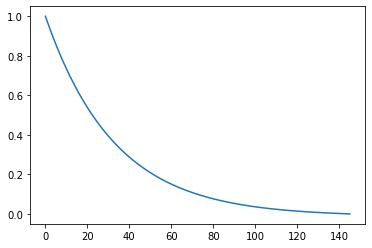

In [21]:
# smoke decay
week_range = np.arange(-12,134)
power      = np.power(0.97, week_range)
power_norm = (power - power.min()) / (power.max() - power.min())
plt.plot(power_norm)

In [22]:
data = preparation(ROOT)
base = make_base(data)

data = data.merge(base, on='Patient', how='left')
print(data.shape)
if ADD_DICOM:
    data = data.merge(dicom_data, on=['Patient',"WHERE"])
    print(data.shape)
data.head(2)

(2254, 15)
(2254, 23)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,last3,last_train,min_week,min_FVC,min_Percent,volume,mean,variance,skewness,kurtosis,lung_area,chest_diameter,chest_circ
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,False,False,-4.0,2315,58.253649,226815.331,-693.257939,67350.755526,1.55782,1.586914,1366.45,103.966,270.995
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,False,False,-4.0,2315,58.253649,226815.331,-693.257939,67350.755526,1.55782,1.586914,1366.45,103.966,270.995


In [23]:
data, FE = feature_engineering(data)

save_cols = ["Patient","FVC","base_week","WHERE",'Patient_Week','Confidence',"last3","last_train"] + FE
#train = data.loc[data.WHERE=='train'].sort_values(by=["Patient","week"], ascending=[True,False]).reset_index(drop=True).copy()
#chunk = data.loc[data.WHERE=='val']  .reset_index(drop=True).copy()
#sub   = data.loc[data.WHERE=='test'] .reset_index(drop=True).copy()
train = data.loc[data.WHERE=='train', save_cols].sort_values(by=["Patient","week"], ascending=[True,False]).reset_index(drop=True).copy()
chunk = data.loc[data.WHERE=='val',   save_cols].reset_index(drop=True).copy()
sub   = data.loc[data.WHERE=='test',  save_cols].reset_index(drop=True).copy()
del data, base
gc.collect()

print(train.shape, chunk.shape, sub.shape)
display(train.head(2))

(1519, 28) (5, 28) (730, 28)


,Patient,FVC,base_week,WHERE,Patient_Week,Confidence,last3,last_train,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
0,ID00007637202177411956430,2315,0.0,train,NaN,NaN,False,False,0.769231,0.820988,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.173871,0.203302,0.198233,0.111561,0.026937,0.02638,0.282303
1,ID00007637202177411956430,2214,9.0,train,NaN,NaN,False,False,0.769231,0.765432,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.162106,0.189545,0.184818,0.104012,0.025114,0.02638,0.282303


In [24]:
print(FE)
print(train[FE].shape)
train[["FVC"]+FE].head()

['age', 'week', 'height', 'bmi', 'bmi_over', 'base_fvc', 'base_percent', 'smoke', 'sex', 'fvc_expected', 'fvc_efvc_diff', 'fvc_efvc_div', 'fvc_per_mul', 'week_height', 'week_bmi', 'week_fvc', 'week_per', 'week_fvc_per', 'lung_volume', 'lung_area']
(1519, 20)


,FVC,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
0,2315,0.769231,0.820988,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.173871,0.203302,0.198233,0.111561,0.026937,0.02638,0.282303
1,2214,0.769231,0.765432,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.162106,0.189545,0.184818,0.104012,0.025114,0.02638,0.282303
2,2061,0.769231,0.753086,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.159491,0.186487,0.181837,0.102334,0.024709,0.02638,0.282303
3,2144,0.769231,0.740741,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.156876,0.183430,0.178856,0.100656,0.024304,0.02638,0.282303
4,2069,0.769231,0.728395,0.211783,0.247631,0.896707,0.241456,0.135886,0.6,0,0.549591,-0.308135,0.582536,0.032811,0.154262,0.180373,0.175875,0.098979,0.023899,0.02638,0.282303


In [25]:
train[["FVC"]+FE].corr()

,FVC,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
FVC,1.000000,-0.101880,0.040399,0.895681,-0.722876,-0.870780,0.963159,0.626944,0.262046,-0.502183,0.596263,0.521150,0.626944,0.842867,0.867178,-0.673832,0.928787,0.607066,0.834625,0.258619,0.410657
age,-0.101880,1.000000,0.028753,0.021926,-0.014107,-0.012252,-0.100696,0.089437,0.014265,-0.041775,-0.223229,0.116278,0.089437,-0.023415,0.031176,-0.008693,-0.086688,0.097256,-0.017292,-0.122551,-0.038396
week,0.040399,0.028753,1.000000,-0.038691,0.043499,0.037303,-0.037544,-0.017171,-0.014003,-0.000084,-0.032404,-0.010591,-0.017171,-0.030609,0.263276,0.261437,0.277006,0.266590,0.129422,-0.024842,-0.013771
height,0.895681,0.021926,-0.038691,1.000000,-0.796517,-0.979916,0.932060,0.823604,0.174636,-0.213289,0.357225,0.737594,0.823604,0.928543,0.942542,-0.761322,0.873100,0.772578,0.905727,0.228123,0.388026
bmi,-0.722876,-0.014107,0.043499,-0.796517,1.000000,0.706625,-0.751928,-0.623256,-0.203817,0.223810,-0.381111,-0.496419,-0.623256,-0.626807,-0.754691,0.966302,-0.707078,-0.587431,-0.613608,-0.122644,-0.186258
bmi_over,-0.870780,-0.012252,0.037303,-0.979916,0.706625,1.000000,-0.907991,-0.810437,-0.150191,0.177859,-0.318503,-0.749853,-0.810437,-0.965595,-0.921928,0.674054,-0.849078,-0.758964,-0.940948,-0.230396,-0.375504
base_fvc,0.963159,-0.100696,-0.037544,0.932060,-0.751928,-0.907991,1.000000,0.651589,0.260869,-0.515018,0.614168,0.546287,0.651589,0.878104,0.877991,-0.718157,0.938423,0.608420,0.856586,0.254660,0.412888
base_percent,0.626944,0.089437,-0.017171,0.823604,-0.623256,-0.810437,0.651589,1.000000,0.081112,0.133255,-0.169073,0.960141,1.000000,0.850425,0.779694,-0.592833,0.611883,0.947943,0.831905,0.112628,0.274914
smoke,0.262046,0.014265,-0.014003,0.174636,-0.203817,-0.150191,0.260869,0.081112,1.000000,-0.350963,0.268822,0.027242,0.081112,0.166552,0.162458,-0.195412,0.244448,0.072004,0.161561,0.055153,0.035279
sex,-0.502183,-0.041775,-0.000084,-0.213289,0.223810,0.177859,-0.515018,0.133255,-0.350963,1.000000,-0.822498,0.255901,0.133255,-0.187262,-0.204317,0.211094,-0.491226,0.127873,-0.185050,-0.078945,-0.204642


In [26]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, C1)
    delta  = np.minimum(np.abs(actual_fvc - predicted_fvc), C2)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

def calculate_scores(y, pred, return_values=False, show=True):
    lll = laplace_log_likelihood(y, pred[:, 1], pred[:, 2]-pred[:,0])
    sigma_opt  = mean_absolute_error(y, pred[:, 1])
    unc        = pred[:,2] - pred[:, 0]
    sigma_mean = np.mean(unc)
    if show:
        print("Laplace log likelihood", lll)
        print("mean_absolute_error", sigma_opt)
        print("uncertainty", sigma_mean, unc.min(), unc.max())
    
    if return_values:
        return lll
    
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma    = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2   = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.25, 0.50, 0.75]
    q  = tf.constant(np.array([qs]), dtype=tf.float32)
    e  = y_true - y_pred
    v  = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z  = L.Input((nh,), name="Patient")
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d1")(z)
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d2")(x)
    x  = L.Dense(100, activation="relu", kernel_initializer='he_normal', name="d3")(x)
    p1 = L.Dense(3,   activation="linear", name="p1")(x)
    p2 = L.Dense(3,   activation="relu",   name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65),
                  optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),
                  metrics=[score])
    return model

In [27]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_score",
    min_delta=0,
    patience=500,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.6,
    patience=150, 
    verbose=1, 
    min_lr=1e-8)

lr_schedule = tf.keras.experimental.CosineDecayRestarts(0.1, 100)
lrs_cdr     = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

callbacks   = [er]

In [28]:
NFOLD      = 12
EPOCHS     = 1200
BATCH_SIZE = 128

In [29]:
%%time
g    = train.Patient
ze   = sub[FE].values
pe   = np.zeros((ze.shape[0], 3))
pred = np.zeros((train.shape[0], 3))
kf   = GroupKFold(n_splits=NFOLD)

for cnt, (tr_idx, val_idx) in enumerate(kf.split(train, groups=g)):
    print(f"FOLD {cnt+1}")
    train_x = (train.iloc[tr_idx, :]).query("last_train")[FE].values
    train_y = (train.iloc[tr_idx, :]).query("last_train")["FVC"].values
    valid_idx = (train.iloc[val_idx,:]).query("last3").index
    valid_x   = train.loc[valid_idx, FE].values
    valid_y   = train.loc[valid_idx, "FVC"].values
    net = make_model(len(FE))
    net.fit(train_x, train_y,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            callbacks=callbacks,
            validation_data=(valid_x, valid_y),
            verbose=0)
    print("train", net.evaluate(train_x, train_y, verbose=0, batch_size=BATCH_SIZE))
    print("valid", net.evaluate(valid_x, valid_y, verbose=0, batch_size=BATCH_SIZE))
    pred[valid_idx] = net.predict (valid_x, verbose=0, batch_size=BATCH_SIZE)
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    del net
    gc.collect()

FOLD 1
Restoring model weights from the end of the best epoch.
Epoch 00511: early stopping
train [69.83926391601562, 7.236663818359375]
valid [69.5147705078125, 7.212793827056885]
FOLD 2
Restoring model weights from the end of the best epoch.
Epoch 00515: early stopping
train [62.902156829833984, 7.049449920654297]
valid [56.24342727661133, 7.070635795593262]
FOLD 3
Restoring model weights from the end of the best epoch.
Epoch 00776: early stopping
train [49.79353332519531, 6.796020030975342]
valid [57.82429885864258, 6.989010810852051]
FOLD 4
Restoring model weights from the end of the best epoch.
Epoch 00580: early stopping
train [56.33857727050781, 6.95413064956665]
valid [61.983245849609375, 6.976849555969238]
FOLD 5
Restoring model weights from the end of the best epoch.
Epoch 00995: early stopping
train [49.87098693847656, 6.791622161865234]
valid [43.48845291137695, 6.6953911781311035]
FOLD 6
Restoring model weights from the end of the best epoch.
Epoch 00658: early stopping
tra

In [30]:
last3_idx  = np.where(pred.sum(1)>0)
last3_pred = pred[last3_idx]
last3_fvc  = train.iloc[last3_idx]["FVC"]
# Reverse normalization
#last3_pred = last3_pred * (fvc_max-fvc_min) + fvc_min
#last3_pred = last3_pred * fvc_std + fvc_mean

calculate_scores(last3_fvc, last3_pred)

Laplace log likelihood -6.940277575343481
mean_absolute_error 190.17774337827018
uncertainty 270.6524975071465 81.447509765625 747.849853515625


# Light GBM

In [31]:
class OSICLossForLGBM:
    """
    Custom Loss for LightGBM.
    
    * Objective : return grad & hess of NLL of gaussian
    * Evaluation: return competition metric
    """
    
    def __init__(self, epsilon: float=1) -> None:
        """Initialize."""
        self.name = "osic_loss"
        self.n_class = 2  # FVC & Confidence
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None) -> float:
        """Calc loss."""
        sigma_clip = np.maximum(preds[:, 1], 70)
        Delta = np.minimum(np.abs(preds[:, 0] - labels), 1000)
        loss_by_sample = - np.sqrt(2) * Delta / sigma_clip - np.log(np.sqrt(2) * sigma_clip)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None
    ) -> tp.Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        mu = preds[:, 0]
        sigma = preds[:, 1]
        
        sigma_t = np.log(1 + np.exp(sigma))
        grad_sigma_t = 1 / (1 + np.exp(- sigma))
        hess_sigma_t = grad_sigma_t * (1 - grad_sigma_t)
        
        grad = np.zeros_like(preds)
        hess = np.zeros_like(preds)
        grad[:, 0] = - (labels - mu) / sigma_t ** 2
        hess[:, 0] = 1 / sigma_t ** 2
        
        tmp = ((labels - mu) / sigma_t) ** 2
        grad[:, 1] = 1 / sigma_t * (1 - tmp) * grad_sigma_t
        hess[:, 1] = (
            - 1 / sigma_t ** 2 * (1 - 3 * tmp) * grad_sigma_t ** 2
            + 1 / sigma_t * (1 - tmp) * hess_sigma_t
        )
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, True
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)
        hess = hess.T.reshape(n_example * self.n_class)
        
        return grad, hess
    
class BaseModel(object):
    """
    Base Model Class:

    train_df         : train pandas dataframe
    test_df          : test pandas dataframe
    target           : target column name (str)
    features         : list of feature names
    categoricals     : list of categorical feature names
    n_splits         : K in KFold (default is 3)
    cv_method        : options are .. KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold, or GroupShuffleSplit
    group            : group feature name when GroupKFold or StratifiedGroupKFold are used
    task             : options are .. regression, multiclass, or binary
    param            : dict of parameter, set that if you already define
    parameter_tuning : bool, only for LGB
    seed             : seed (int)
    verbose          : bool
    """

    def __init__(self, train_df, test_df, target, features, 
                 valid_df=None, categoricals=[],
                 alpha=0, custom_loss=None,
                 n_splits=3, cv_method="KFold", group=None,
                 task="regression", params=None, parameter_tuning=False,
                 seed=42, verbose=True):
        self.train_df     = train_df
        if valid_df is not None and valid_df.shape[0]==0:
            self.valid_df = None            
        else:
            self.valid_df = valid_df
        self.test_df      = test_df
        self.target       = target
        self.features     = features
        self.n_splits     = n_splits
        self.categoricals = categoricals
        self.alpha        = alpha
        self.custom_loss  = custom_loss
        self.cv_method    = cv_method
        self.group        = group
        self.task         = task
        self.parameter_tuning = parameter_tuning
        self.seed    = seed
        self.cv      = self.get_cv()
        self.verbose = verbose
        if params is None:
            self.params = self.get_params()
        else:
            self.params = params
        self.y_pred, self.y_valid, self.score, self.model, self.oof, self.y_val, self.fi_df = self.fit()

    def train_model(self, train_set, val_set):
        raise NotImplementedError

    def get_params(self):
        raise NotImplementedError

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError

    def calc_metric(self, y_true, y_pred): # this may need to be changed based on the metric of interest
        if   self.task in ("multiclass","nn_multiclass"):
            preds = np.argmax(y_pred, axis=1) if y_true.shape != y_pred.shape else y_pred
            return f1_score(y_true, preds, average='macro')                
        elif self.task == "binary":
            return f1_score(y_true, y_pred, average='macro')
        elif self.task in ("regression","quantile"):
            return np.sqrt(mean_squared_error(y_true, y_pred))
        elif self.task == "custom_loss":
            if y_pred.ndim==2:
                return np.sqrt(mean_squared_error(y_true, y_pred[:,0]))
            else:
                return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def get_cv(self):
        if self.cv_method == "KFold":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df)
        if self.cv_method == "StratifiedKFold":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
            return cv.split(self.train_df, self.train_df[self.target])
        if self.cv_method == "TimeSeriesSplit":
            cv = TimeSeriesSplit(max_train_size=None, n_splits=self.n_splits)
            return cv.split(self.train_df)
        if self.cv_method == "GroupKFold":
            if self.group in self.features:
                self.features.remove(self.group)
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df[self.features], self.train_df[self.target], self.train_df[self.group])
        if self.cv_method == "GroupShuffleSplit":
            if self.group in self.features:
                self.features.remove(self.group)
            cv = GroupShuffleSplit(n_splits=self.n_splits, random_state=self.seed)
            return cv.split(self.train_df[self.features], self.train_df[self.target], self.train_df[self.group])

    def fit(self):
        # Initialize
        y_vals = np.zeros((self.train_df.shape[0], ))
        if self.task in ("multiclass","nn_multiclass"):
            col_len = self.train_df[self.target].nunique()
        elif self.task == "custom_loss":
            col_len = 2
        else:
            col_len = 1
        oof_pred = np.zeros((self.train_df.shape[0], col_len))
        y_pred   = np.zeros((self.test_df.shape[0],  col_len))
        y_valid  = np.zeros((self.valid_df.shape[0], col_len)) if self.valid_df is not None else None
            
        if self.group is not None:
            if self.group in self.features:
                self.features.remove(self.group)
            if self.group in self.categoricals:
                self.categoricals.remove(self.group)
                
        fi = np.zeros((self.n_splits, len(self.features)))
        if y_valid is not None:
            x_valid = self.valid_df[self.features].copy()
            del self.valid_df
            gc.collect()
        x_test = self.test_df[self.features]

        # Fitting with out of fold
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # Prepare train and test dataset
            x_train = self.train_df.iloc[train_idx, :].query("last_train")[self.features]
            y_train = self.train_df.iloc[train_idx, :].query("last_train")[self.target]
            last3_val_idx = self.train_df.iloc[val_idx, :].query("last3").index
            x_val   = self.train_df.iloc[last3_val_idx, :][self.features]
            y_val   = self.train_df.iloc[last3_val_idx, :][self.target]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            del x_train, y_train
            gc.collect()
            
            # Fit model
            model, importance = self.train_model(train_set, val_set)
            fi[fold, :]       = importance
            y_vals[last3_val_idx] = y_val
            
            # Get some scores
            oof_pred[last3_val_idx] = model.predict(x_val).reshape(oof_pred[last3_val_idx].shape)
            if y_valid is not None:
                y_valid += model.predict(x_valid).reshape(y_valid.shape) / self.n_splits
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
                
            print('Partial score of fold {} is: {}'.format(fold, self.calc_metric(y_val, oof_pred[last3_val_idx])))
        
        # Create feature importance data frame
        fi_df = pd.DataFrame()
        for n in np.arange(self.n_splits):
            tmp = pd.DataFrame()
            tmp["features"]   = self.features
            tmp["importance"] = fi[n, :]
            tmp["fold"]       = n
            fi_df = pd.concat([fi_df, tmp], ignore_index=True)
        gfi   = fi_df[["features", "importance"]].groupby(["features"]).mean().reset_index()
        fi_df = fi_df.merge(gfi, on="features", how="left", suffixes=('', '_mean'))
        
        # Calculate oof score
        
        last3_idx  = np.where(oof_pred.sum(1)>0)
        last3_pred = oof_pred[last3_idx]
        last3_fvc  = y_vals[last3_idx]
        loss_score = self.calc_metric(last3_fvc, last3_pred)
        print('Our oof loss score is: ', loss_score)
        
        return y_pred, y_valid, loss_score, model, oof_pred, y_vals, fi_df

    def plot_feature_importance(self, rank_range=[1, 50]):
        fig, ax   = plt.subplots(1, 1, figsize=(10, 5))
        sorted_df = self.fi_df.sort_values(by="importance_mean", ascending=False).reset_index()
        sns.barplot(data=sorted_df.iloc[self.n_splits*(rank_range[0]-1) : self.n_splits*rank_range[1]],
                    x="importance", y="features", orient='h')
        ax.set_xlabel("feature importance")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        return sorted_df
    
class LgbModel(BaseModel):
    """
    LGB wrapper
    """
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        if self.task == "custom_loss":
            model = lgb.train(self.params, train_set, num_boost_round=10000,
                              valid_sets=[train_set, val_set], verbose_eval=verbosity,
                              fobj=self.custom_loss.return_grad_and_hess,
                              feval=self.custom_loss.return_loss)
        else:
            model = lgb.train(self.params, train_set, num_boost_round=5000,
                              valid_sets=[train_set, val_set], verbose_eval=verbosity)
        fi = model.feature_importance(importance_type="gain")
        return model, fi

    def convert_dataset(self, x_train, y_train, x_val=None, y_val=None):
        train_set   = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        if x_val is not None:
            val_set = lgb.Dataset(x_val,   y_val,   categorical_feature=self.categoricals)
            return train_set, val_set
        return train_set

    def get_params(self):
        # Fast fit parameters
        params = {
            'boosting_type'    : "gbdt",
            'objective'        : self.task,
            "subsample"        : 0.4,
            "subsample_freq"   : 1,
            'max_depth'        : 1,
            'min_data_in_leaf' : 50,
            'learning_rate'    : 0.05,
            'early_stopping_rounds' : 500,
            'bagging_seed'     : 11,
            'random_state'     : 42,
            'verbosity'        : -1
        }

        # List is here: https://lightgbm.readthedocs.io/en/latest/Parameters.html
        if   self.task == "regression":
            params["metric"]    = "regression_l2"
        elif self.task == "quantile":
            params["metric"]    = "quantile"
            params["alpha"]     = self.alpha
        elif self.task == "custom_loss":
            del params["objective"]
            params["num_class"] = 2
            params["metric"]    = 'None'
        elif self.task == "binary":
            params["metric"]    = "binary_logloss"
        elif self.task == "multiclass":
            params["metric"]    = "multi_logloss"
            params["num_class"] = len(self.train_df[self.target].unique())
            
        # Bayesian Optimization by Optuna
        if self.parameter_tuning:
            # Define objective function
            def objective(trial):
                # Split train and test data
                
                train_x, test_x, train_y, test_y = train_test_split(self.train_df[self.features], 
                                                                    self.train_df[self.target],
                                                                    test_size=0.3, random_state=self.seed)
                
                dtrain = lgb.Dataset(train_x, train_y, categorical_feature=self.categoricals)
                dtest  = lgb.Dataset(test_x,  test_y,  categorical_feature=self.categoricals)

                # Parameters to be explored
                hyperparams = {'max_depth'         : trial.suggest_int('max_depth', 1, 1),
                               "subsample"         : trial.suggest_uniform('subsample', 0.2, 0.5),
                               "subsample_freq"    : trial.suggest_int('subsample_freq', 1, 1),
                               'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 20),
                               'feature_fraction'  : trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                               'bagging_fraction'  : trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                               'bagging_freq'      : trial.suggest_int('bagging_freq', 1, 7),
                               'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
                               'lambda_l1'         : trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                               'lambda_l2'         : trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                               'early_stopping_rounds' : 500}
                # LGBM
                params.update(hyperparams)
                verbosity = 500 if self.verbose else 0
                if self.task == "custom_loss":
                    model = lgb.train(params, dtrain, valid_sets=dtest, verbose_eval=verbosity,
                                      fobj=self.custom_loss.return_grad_and_hess,
                                      feval=self.custom_loss.return_loss)
                else:
                    model = lgb.train(params, dtrain, valid_sets=dtest, verbose_eval=verbosity)
                pred  = model.predict(test_x)
                return self.calc_metric(test_y, pred)

            # Run optimization
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=50)
            print('Number of finished trials: {}'.format(len(study.trials)))
            print('Best trial:')
            trial = study.best_trial
            print('  Value: {}'.format(trial.value))
            print('  Params: ')
            for key, value in trial.params.items():
                print('    {}: {}'.format(key, value))

            params.update(trial.params)
            #params["learning_rate"] = 0.001
            # Plot history
            plot_optimization_history(study)
            
        return params

In [32]:
exec_custom_loss = True
exec_regression  = True

In [33]:
if exec_custom_loss:
    lgbm_p1_c = LgbModel(train, sub, "FVC", FE,
                         valid_df=None, task="custom_loss", custom_loss=OSICLossForLGBM(),
                         cv_method="GroupKFold", n_splits=10, group="Patient", 
                         params=None, parameter_tuning=True, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-10-06 16:25:20,114] Finished trial#0 with value: 242.74969534333212 with parameters: {'max_depth': 1, 'subsample': 0.3378024970064198, 'subsample_freq': 1, 'min_child_weight': 19, 'feature_fraction': 0.6142480447337502, 'bagging_fraction': 0.8862222015385499, 'bagging_freq': 2, 'min_child_samples': 43, 'lambda_l1': 0.0002161311277677203, 'lambda_l2': 3.017725884862289e-08}. Best is trial#0 with value: 242.74969534333212.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.

Number of finished trials: 50
Best trial:
  Value: 241.34021142433537
  Params: 
    max_depth: 1
    subsample: 0.4215781472507265
    subsample_freq: 1
    min_child_weight: 12
    feature_fraction: 0.5908215110535308
    bagging_fraction: 0.8556093454529353
    bagging_freq: 1
    min_child_samples: 14
    lambda_l1: 0.0001493491446526647
    lambda_l2: 2.868257802515043e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 294.6625218495812


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 232.21929622182822


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 230.67341670285688


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 309.1894124436011


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 321.42834626615235


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 5 is: 331.76847881507604


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 6 is: 301.5196172943625


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 7 is: 190.94260074747365


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 8 is: 583.8217760148864


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 9 is: 330.6029003130478
Our oof loss score is:  327.90418085986863


In [34]:
if exec_regression:
    lgbm_p1 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="regression",
                       cv_method="GroupKFold", n_splits=10, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)    

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:26:12,290] Finished trial#0 with value: 252.47007089053685 with parameters: {'max_depth': 1, 'subsample': 0.425215357152785, 'subsample_freq': 1, 'min_child_weight': 5, 'feature_fraction': 0.5462273576390038, 'bagging_fraction': 0.4856714555641275, 'bagging_freq': 7, 'min_child_samples': 11, 'lambda_l1': 0.00083657632498305, 'lambda_l2': 2.893860287885714e-05}. Best is trial#0 with value: 252.47007089053685.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:26:12,993] Finished 

Number of finished trials: 50
Best trial:
  Value: 242.49203885598752
  Params: 
    max_depth: 1
    subsample: 0.27036017019264796
    subsample_freq: 1
    min_child_weight: 20
    feature_fraction: 0.9947947283709854
    bagging_fraction: 0.899172933051263
    bagging_freq: 1
    min_child_samples: 82
    lambda_l1: 0.0016190833385680131
    lambda_l2: 1.8394836456699808e-06


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 253.03489488407405


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 238.85806316809283


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 216.76714616864592


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 275.79539328064504


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 333.18061464003


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 5 is: 320.59868780880373


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 6 is: 305.15179894025545


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 7 is: 194.6156711034194


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 8 is: 425.5026502260957


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 9 is: 305.37120116144973
Our oof loss score is:  293.80126616373417


In [35]:
if exec_regression:
    lgbm_p0 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="quantile", alpha=0.25,
                       cv_method="GroupKFold", n_splits=10, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:27:00,462] Finished trial#0 with value: 367.51626828133953 with parameters: {'max_depth': 1, 'subsample': 0.3249099991790472, 'subsample_freq': 1, 'min_child_weight': 8, 'feature_fraction': 0.5897182615664059, 'bagging_fraction': 0.6883659985958659, 'bagging_freq': 3, 'min_child_samples': 75, 'lambda_l1': 7.72915264872221e-07, 'lambda_l2': 5.009800484175387e-05}. Best is trial#0 with value: 367.51626828133953.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:27:01,208] Finishe

Number of finished trials: 50
Best trial:
  Value: 356.41012743833807
  Params: 
    max_depth: 1
    subsample: 0.27718080813388235
    subsample_freq: 1
    min_child_weight: 6
    feature_fraction: 0.9762981269572201
    bagging_fraction: 0.9200689299427598
    bagging_freq: 7
    min_child_samples: 54
    lambda_l1: 1.1670921854586473e-06
    lambda_l2: 6.396206130689364e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 305.65996983971894


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 260.52595090789004


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 278.504518617475


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 369.7671357393672


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 352.77014906464524


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 5 is: 353.2077639271951


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 6 is: 316.3304577509628


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 7 is: 240.61238434533252


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 8 is: 639.684374470348


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 9 is: 350.97631676737916
Our oof loss score is:  361.70479988404935


In [36]:
if exec_regression:
    lgbm_p2 = LgbModel(train, sub, "FVC", FE,
                       valid_df=None, task="quantile", alpha=0.75,
                       cv_method="GroupKFold", n_splits=10, group="Patient", 
                       params=None, parameter_tuning=True, verbose=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:27:49,265] Finished trial#0 with value: 343.1545539703745 with parameters: {'max_depth': 1, 'subsample': 0.4882938116186301, 'subsample_freq': 1, 'min_child_weight': 5, 'feature_fraction': 0.7888003507996926, 'bagging_fraction': 0.9187299302602653, 'bagging_freq': 1, 'min_child_samples': 98, 'lambda_l1': 6.250855286314994e-08, 'lambda_l2': 0.05634116747522494}. Best is trial#0 with value: 343.1545539703745.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-10-06 16:27:49,978] Finished t

Number of finished trials: 50
Best trial:
  Value: 330.00990467476487
  Params: 
    max_depth: 1
    subsample: 0.40128183474239193
    subsample_freq: 1
    min_child_weight: 3
    feature_fraction: 0.994322429606695
    bagging_fraction: 0.99687629595414
    bagging_freq: 2
    min_child_samples: 56
    lambda_l1: 3.3010754623689422
    lambda_l2: 0.329006719512464


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 0 is: 274.2891451176172


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 1 is: 268.3979104432825


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 2 is: 244.70747871121657


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 3 is: 338.13619866117324


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 4 is: 383.40321569578344


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 5 is: 346.84608787082453


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 6 is: 367.69229435874735


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 7 is: 249.72549642571823


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 8 is: 536.1690113610812


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Partial score of fold 9 is: 347.5004703310408
Our oof loss score is:  345.51971043331656


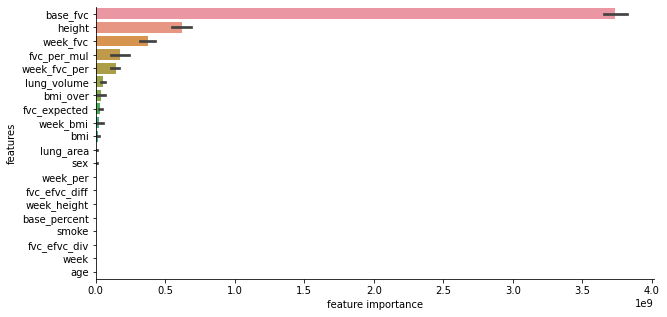

In [37]:
if exec_custom_loss:
    df_imp = lgbm_p1_c.plot_feature_importance()

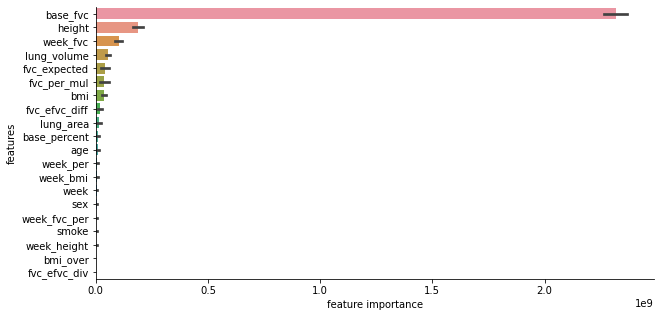

In [38]:
if exec_regression:
    df_imp = lgbm_p1.plot_feature_importance()

In [39]:
def change_values(idx, ary):
    tmp_min = ary[idx].min()
    tmp_med = np.median(ary[idx])
    tmp_max = ary[idx].max()
    ary[idx,0] = tmp_min
    ary[idx,1] = tmp_med
    ary[idx,2] = tmp_max
    print("pred_lgbm", ary[idx])
    return ary

if exec_regression:
    pred_lgbm = np.hstack([lgbm_p0.oof,    lgbm_p1.oof,    lgbm_p2.oof])
    pe_lgbm   = np.hstack([lgbm_p0.y_pred, lgbm_p1.y_pred, lgbm_p2.y_pred])

    for idx in np.where((pred_lgbm[:,2]-pred_lgbm[:,0])<0)[0]:
        pred_lgbm = change_values(idx, pred_lgbm)
    for idx in np.where((pe_lgbm[:,2]-pe_lgbm[:,0])<0)[0]:
        pe_lgbm   = change_values(idx, pe_lgbm)
        
if exec_custom_loss:
    pred_lgbm_c = np.vstack([lgbm_p1_c.oof[:,0]-(lgbm_p1_c.oof[:,1]/2),
                             lgbm_p1_c.oof[:,0],
                             lgbm_p1_c.oof[:,0]+(lgbm_p1_c.oof[:,1]/2)]).T
    pe_lgbm_c   = np.vstack([lgbm_p1_c.y_pred[:,0]-(lgbm_p1_c.y_pred[:,1]/2),
                             lgbm_p1_c.y_pred[:,0],
                             lgbm_p1_c.y_pred[:,0]+(lgbm_p1_c.y_pred[:,1]/2)]).T

pred_lgbm [2771.88950275 2856.19244414 2877.64372085]
pred_lgbm [3592.09022391 3593.90392325 3760.80540024]
pred_lgbm [3541.07909667 3544.58263285 3745.26251287]
pred_lgbm [2881.6366175  2908.95499314 2932.56736825]


In [40]:
emsambles = []

if exec_regression and exec_custom_loss:
    for a in np.arange(0,1.01,0.05):
        a = round(a,2)
        a_max = round(1-a,2)
        for b in np.arange(0,a_max+0.01,0.05):
            b = round(b,2)
            c = round((a_max-b),2)
            emsambled  = a*pred_lgbm + b*pred_lgbm_c + c*pred
            last3_pred = emsambled[np.where(emsambled.sum(1))]
            last3_fvc  = train.query("last3").FVC
            lll = calculate_scores(last3_fvc, last3_pred, True, False)
            emsambles.append([a,b,c,lll])
    df_result_pred = pd.DataFrame(emsambles, columns=["a","b","c","lll"])
    a, b, c   = df_result_pred.sort_values(by="lll", ascending=False).iloc[0,:3]
    best_pred = a*pred_lgbm + b*pred_lgbm_c + c*pred
    print("Best emsamble parameters are %s,%s,%s" % (a,b,c))

else:
    for a in np.arange(0,1.1,0.1):
        a = round(a,1)
        print(a)
        emsambled  = a*pred_lgbm + (1-a)*pred if exec_regression else a*pred_lgbm_c + (1-a)*pred
        last3_pred = emsambled[np.where(emsambled.sum(1))]
        last3_fvc  = train.query("last3").FVC
        lll = calculate_scores(last3_fvc, last3_pred, True)
        emsambles.append([a,lll])
    
    a = emsambles[np.argmax(np.array(emsambles)[:,1])][0]
    best_pred = a*pred_lgbm + (1-a)*pred if exec_regression else a*pred_lgbm_c + (1-a)*pred
    print("Best emsamble parameter is %s" % a)

Best emsamble parameters are 0.15,0.05,0.8


In [41]:
last3_pred = best_pred[np.where(best_pred.sum(1))]
last3_fvc  = train.query("last3").FVC
calculate_scores(last3_fvc, last3_pred)

Laplace log likelihood -6.914628193602129
mean_absolute_error 185.67538766092204
uncertainty 259.0451038834 96.47227088002796 634.3850109224841


In [42]:
df_pred_results = pd.DataFrame({"Patient" :train.query("last3").Patient.values,
                                "Pred_q25":last3_pred[:,0],
                                "Pred_q50":last3_pred[:,1],
                                "Pred_q75":last3_pred[:,2],
                                "GT":last3_fvc.values})
metric = []
for p in df_pred_results.Patient.unique():
    df_p = df_pred_results.query("Patient == @p")
    lll  = calculate_scores(df_p.GT, np.array([df_p.Pred_q25, df_p.Pred_q50, df_p.Pred_q75]),
                            show=False, return_values=True)
    metric.append([p, lll])
df_p_score = pd.DataFrame(metric, columns=["Patient", "score"])
df_p_score = df_p_score.sort_values(by="score").reset_index(drop=True)
display(df_p_score.head(10))

,Patient,score
0,ID00110637202210673668310,-21.556127
1,ID00076637202199015035026,-18.675001
2,ID00014637202177757139317,-18.530821
3,ID00249637202266730854017,-18.038143
4,ID00225637202259339837603,-17.899795
5,ID00010637202177584971671,-17.036863
6,ID00197637202246865691526,-16.972185
7,ID00364637202296074419422,-15.818011
8,ID00170637202238079193844,-15.672560
9,ID00186637202242472088675,-15.554655


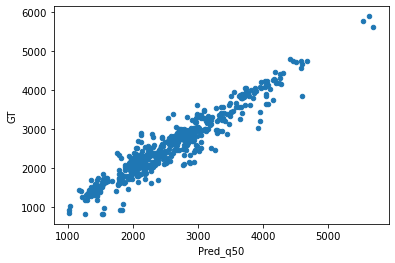

In [43]:
df_pred_results.plot(x="Pred_q50", y="GT", kind="scatter")

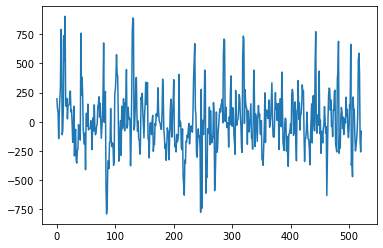

In [44]:
residual = df_pred_results.Pred_q50 - df_pred_results.GT
plt.plot(residual)

In [45]:
for p in df_p_score.Patient.unique()[:3]:
    display(df_pred_results.query("Patient==@p"))
    display(train.query("Patient==@p"))

,Patient,Pred_q25,Pred_q50,Pred_q75,GT
129,ID00110637202210673668310,1740.313851,1851.017017,2032.894381,1085
130,ID00110637202210673668310,1713.378034,1828.210572,2007.595748,938
131,ID00110637202210673668310,1683.439787,1797.822020,1974.035223,919


,Patient,FVC,base_week,WHERE,Patient_Week,Confidence,last3,last_train,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
374,ID00110637202210673668310,1995,0.0,train,NaN,NaN,False,False,0.641026,0.820988,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.109416,0.409113,0.149437,0.144763,0.026350,0.013358,0.132951
375,ID00110637202210673668310,1884,3.0,train,NaN,NaN,False,False,0.641026,0.802469,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.106948,0.399885,0.146066,0.141498,0.025756,0.013358,0.132951
376,ID00110637202210673668310,1806,5.0,train,NaN,NaN,False,False,0.641026,0.790123,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.105303,0.393733,0.143819,0.139321,0.025359,0.013358,0.132951
377,ID00110637202210673668310,1666,8.0,train,NaN,NaN,False,False,0.641026,0.771605,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.102835,0.384505,0.140448,0.136056,0.024765,0.013358,0.132951
378,ID00110637202210673668310,1316,10.0,train,NaN,NaN,False,False,0.641026,0.759259,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.101189,0.378353,0.138201,0.133879,0.024369,0.013358,0.132951
379,ID00110637202210673668310,1085,16.0,train,NaN,NaN,True,True,0.641026,0.722222,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.096253,0.359897,0.131459,0.127348,0.023180,0.013358,0.132951
380,ID00110637202210673668310,938,27.0,train,NaN,NaN,True,True,0.641026,0.654321,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.087204,0.326060,0.119100,0.115375,0.021001,0.013358,0.132951
381,ID00110637202210673668310,919,41.0,train,NaN,NaN,True,True,0.641026,0.567901,0.133274,0.498318,0.941798,0.182021,0.176328,0.6,0,0.402563,-0.220542,0.626885,0.032095,0.075686,0.282996,0.103370,0.100137,0.018227,0.013358,0.132951


,Patient,Pred_q25,Pred_q50,Pred_q75,GT
84,ID00076637202199015035026,2009.880157,2124.386738,2231.508247,2683
85,ID00076637202199015035026,2005.433091,2123.396308,2230.407271,2914
86,ID00076637202199015035026,1992.928954,2120.803793,2227.753037,2853


,Patient,FVC,base_week,WHERE,Patient_Week,Confidence,last3,last_train,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
241,ID00076637202199015035026,2298,0.0,train,NaN,NaN,False,False,0.051282,0.820988,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.114870,0.297252,0.195640,0.070357,0.016766,0.036439,0.349271
242,ID00076637202199015035026,2576,7.0,train,NaN,NaN,False,False,0.051282,0.777778,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.108824,0.281607,0.185343,0.066654,0.015884,0.036439,0.349271
243,ID00076637202199015035026,2182,9.0,train,NaN,NaN,False,False,0.051282,0.765432,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.107097,0.277138,0.182401,0.065596,0.015631,0.036439,0.349271
244,ID00076637202199015035026,2374,10.0,train,NaN,NaN,False,False,0.051282,0.759259,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.106233,0.274903,0.180930,0.065067,0.015505,0.036439,0.349271
245,ID00076637202199015035026,2370,13.0,train,NaN,NaN,False,False,0.051282,0.740741,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.103642,0.268198,0.176518,0.063480,0.015127,0.036439,0.349271
246,ID00076637202199015035026,2480,19.0,train,NaN,NaN,False,False,0.051282,0.703704,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.098460,0.254788,0.167692,0.060306,0.014371,0.036439,0.349271
247,ID00076637202199015035026,2683,31.0,train,NaN,NaN,True,True,0.051282,0.629630,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.088096,0.227968,0.150040,0.053958,0.012858,0.036439,0.349271
248,ID00076637202199015035026,2914,44.0,train,NaN,NaN,True,True,0.051282,0.549383,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.076868,0.198913,0.130917,0.047081,0.011219,0.036439,0.349271
249,ID00076637202199015035026,2853,59.0,train,NaN,NaN,True,True,0.051282,0.456790,0.139917,0.362067,0.938293,0.238299,0.085698,0.0,0,0.620617,-0.382318,0.5275,0.020422,0.063913,0.165389,0.108852,0.039146,0.009328,0.036439,0.349271


,Patient,Pred_q25,Pred_q50,Pred_q75,GT
12,ID00014637202177757139317,3774.979335,3959.115681,4076.584127,3221
13,ID00014637202177757139317,3772.400038,3956.953572,4074.849362,3439
14,ID00014637202177757139317,3748.553074,3931.340667,4052.449708,3027


,Patient,FVC,base_week,WHERE,Patient_Week,Confidence,last3,last_train,age,week,height,bmi,bmi_over,base_fvc,base_percent,smoke,sex,fvc_expected,fvc_efvc_diff,fvc_efvc_div,fvc_per_mul,week_height,week_bmi,week_fvc,week_per,week_fvc_per,lung_volume,lung_area
36,ID00014637202177757139317,3807,0.0,train,NaN,NaN,False,False,0.179487,0.820988,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.350098,0.101779,0.425742,0.349808,0.181401,0.054252,0.590204
37,ID00014637202177757139317,3897,2.0,train,NaN,NaN,False,False,0.179487,0.808642,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.344834,0.100248,0.419340,0.344547,0.178673,0.054252,0.590204
38,ID00014637202177757139317,3615,4.0,train,NaN,NaN,False,False,0.179487,0.796296,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.339569,0.098718,0.412938,0.339287,0.175945,0.054252,0.590204
39,ID00014637202177757139317,3786,6.0,train,NaN,NaN,False,False,0.179487,0.783951,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.334305,0.097187,0.406536,0.334027,0.173218,0.054252,0.590204
40,ID00014637202177757139317,3756,8.0,train,NaN,NaN,False,False,0.179487,0.771605,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.329040,0.095657,0.400134,0.328767,0.170490,0.054252,0.590204
41,ID00014637202177757139317,3238,14.0,train,NaN,NaN,False,False,0.179487,0.734568,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.313246,0.091065,0.380927,0.312986,0.162306,0.054252,0.590204
42,ID00014637202177757139317,3221,26.0,train,NaN,NaN,True,True,0.179487,0.660494,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.281658,0.081882,0.342515,0.281424,0.145939,0.054252,0.590204
43,ID00014637202177757139317,3439,37.0,train,NaN,NaN,True,True,0.179487,0.592593,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.252703,0.073464,0.307303,0.252493,0.130936,0.054252,0.590204
44,ID00014637202177757139317,3027,54.0,train,NaN,NaN,True,True,0.179487,0.487654,0.426436,0.123971,0.732524,0.518574,0.426082,0.6,0,0.596471,-0.077897,0.900767,0.220955,0.207953,0.060455,0.252885,0.207781,0.107749,0.054252,0.590204


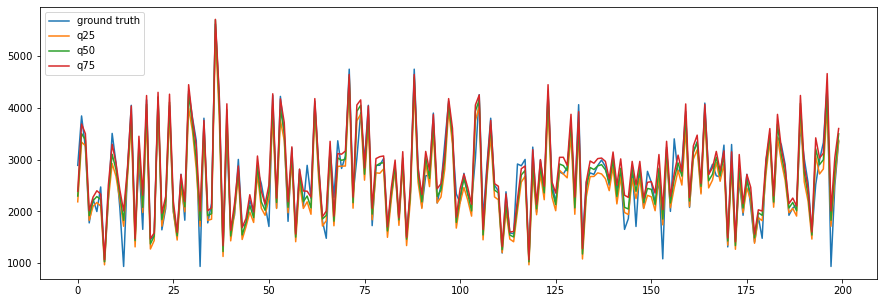

In [46]:
plt.figure(figsize=(15,5))
idxs = np.random.randint(0, last3_pred.shape[0], 200)
plt.plot(last3_fvc.values[idxs], label="ground truth")
plt.plot(last3_pred[idxs, 0], label="q25")
plt.plot(last3_pred[idxs, 1], label="q50")
plt.plot(last3_pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

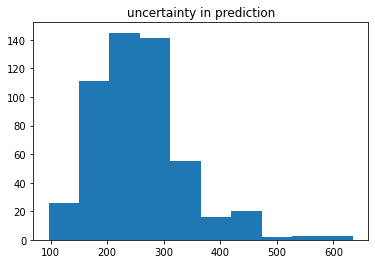

In [47]:
plt.hist(last3_pred[:, 2]-last3_pred[:, 0])
plt.title("uncertainty in prediction")
plt.show()

In [48]:
# PREDICTION
if exec_regression and exec_custom_loss:
    sub['FVC1']        = a*pe_lgbm[:, 1] + b*pe_lgbm_c[:, 1] + c*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm[:, 2] - pe_lgbm[:, 0]) + b*(pe_lgbm_c[:, 2] - pe_lgbm_c[:, 0]) + c*(pe[:, 2] - pe[:, 0])
elif exec_regression:
    sub['FVC1']        = a*pe_lgbm[:, 1] + (1-a)*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm[:, 2] - pe_lgbm[:, 0]) + (1-a)*(pe[:, 2] - pe[:, 0])
else:
    sub['FVC1']        = a*pe_lgbm_c[:, 1] + (1-a)*pe[:, 1]
    sub['Confidence1'] = a*(pe_lgbm_c[:, 2] - pe_lgbm_c[:, 0]) + (1-a)*(pe[:, 2] - pe[:, 0])

subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [49]:
display(subm.head())
subm[["FVC","Confidence"]].describe().T

,Patient_Week,FVC,Confidence,FVC1,Confidence1
0,ID00419637202311204720264_-12,2960.216204,285.441063,2960.216204,285.441063
1,ID00419637202311204720264_-11,2957.682048,285.193639,2957.682048,285.193639
2,ID00419637202311204720264_-10,2955.147820,284.946495,2955.147820,284.946495
3,ID00419637202311204720264_-9,2952.613726,284.699169,2952.613726,284.699169
4,ID00419637202311204720264_-8,2950.079534,284.451854,2950.079534,284.451854


,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2557.090953,402.017980,1783.642775,2468.731918,2657.173892,2826.491775,3167.427423
Confidence,730.0,264.729841,35.344913,193.908930,260.025060,271.743836,281.839716,321.865476


In [50]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [51]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

# Ensemble (Simple Blend)

In [52]:
if USE_ALL:
    emsambles = []
    for a in np.arange(0,1.1,0.05):
        a = round(a,2)
        emsambled = a*last3_pred_img + (1-a)*last3_pred
        lll = calculate_scores(last3_fvc, emsambled, True, False)
        emsambles.append([a,lll])
    best_a = emsambles[np.argmax(np.array(emsambles)[:,1])][0]
    best_pred = best_a*last3_pred_img + (1-best_a)*last3_pred
    print("Best emsamble parameter is %s" % best_a)
    calculate_scores(last3_fvc, best_pred, show=True)
else:
    best_a = 0.3

Best emsamble parameter is 0.2
Laplace log likelihood -6.904767648978646
mean_absolute_error 184.81360293338813
uncertainty 253.63241261949483 94.10857428234192 557.600370242917


In [53]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [54]:
df = df1[['Patient_Week']].copy()
df['FVC']        = best_a*df1['FVC']        + (1-best_a)*df2['FVC']
df['Confidence'] = best_a*df1['Confidence'] + (1-best_a)*df2['Confidence']
print(df.shape)
sample_submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission = sample_submission[["Patient_Week"]].merge(df, on="Patient_Week")
print(submission.shape)
submission.head()

(730, 3)
(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2986.709259,256.926518
1,ID00421637202311550012437_-12,2741.817146,263.875377
2,ID00422637202311677017371_-12,1920.724434,185.999035
3,ID00423637202312137826377_-12,3215.784594,296.386817
4,ID00426637202313170790466_-12,2843.451366,241.151653


In [55]:
submission.to_csv('submission.csv', index=False)